In [ ]:
!pip install -q tfds-nightly
!pip install tensorflow-gpu

     |████████████████████████████████| 4.3 MB 5.3 MB/s 
     |████████████████████████████████| 86 kB 4.1 MB/s 
     |████████████████████████████████| 497.5 MB 25 kB/s 
     |████████████████████████████████| 462 kB 45.2 MB/s 


In [ ]:
!pip install pyvi !pip install -U pip setuptools wheel
!pip install -U spacy
!python -m spacy download ja_core_news_sm

ERROR: Invalid requirement: '!pip'
     |████████████████████████████████| 6.0 MB 4.2 MB/s 
     |████████████████████████████████| 451 kB 41.1 MB/s 
     |████████████████████████████████| 42 kB 1.2 MB/s 
     |████████████████████████████████| 181 kB 45.8 MB/s 
     |████████████████████████████████| 10.1 MB 31.6 MB/s 
     |████████████████████████████████| 653 kB 44.1 MB/s 
  Attempting uninstall: catalogue
    Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Attempting uninstall: srsly
    Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srsly-1.0.5
  Attempting uninstall: thinc
    Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Attempting uninstall: spacy
    Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4
     |█████

In [ ]:
# from underthesea import word_tokenize
from nltk.tokenize import word_tokenize
import gensim
import pandas as pd
import re
import numpy as np
import multiprocessing

import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [ ]:
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/Project/dataMe/text.xlsx").drop(columns=["Unnamed: 0"])
vi_input = dataset["Viet"]
cn_input = dataset["Trung"]

FileNotFoundError: ignored

In [ ]:
def preproces_cn(s):
  return re.sub('\s+', ' ', ' '.join(s))
  seg_list = jieba.cut(s)
  return " ".join(seg_list)

  
for i in range(len(dataset_vn)):
  dataset_vn[i] = dataset_vn[i].lower()
  # content_cn.append(i['en'].lower())
  # content_vn.append(i['vn'].lower())
for i in range(len(dataset_cn)):
  dataset_cn[i] = preproces_cn(dataset_cn[i])


In [ ]:
# tai spacy tieng Trung
!python -m spacy download zh_core_web_sm

In [ ]:
import spacy
from spacy.lang.zh.examples import sentences 

nlp = spacy.load("zh_core_web_sm")
def create_lang_cn():
  lang = []
  for sent in cn_input:
    doc = nlp(sent)
    for token in doc:
      lang.append(token.text)
    lang = list(set(lang))

  return lang

lang_cn = create_lang_cn()


In [ ]:
# def create_lang_vn():
from underthesea import word_tokenize
def create_lang_vn():
  lang = []
  for sent in vi_input:
    doc = word_tokenize(sent)
    lang.extend(doc)
    lang = list(set(lang))

  return lang

lang_vn = create_lang_vn()


In [ ]:
def prepare_vocab(lang):
    vocab = [" "]
    vocab.extend(sorted(lang))
    vocab.append('<START>')
    vocab.append('<END>')
    vocab_size = len(vocab)
    char2idx = {u:i for i, u in enumerate(vocab)}
    idx2char = np.array(vocab)
    return vocab_size, char2idx, idx2char

INPUT_VOCAB_SIZE, input_char2idx, input_idx2char = prepare_vocab(lang_cn)
TARGET_VOCAB_SIZE, target_char2idx, target_idx2char = prepare_vocab(lang_vn)

In [ ]:
nlp = spacy.load("zh_core_web_sm")
def tach_tu_trung(text):
  words = []
  doc = nlp(text)
  for token in doc:
    words.append(token.text)
  return words
input_texts_as_int = [[input_char2idx[c] for c in tach_tu_trung(text)] for text in cn_input]
target_texts_as_int = [[target_char2idx[c] for c in word_tokenize(text)] for text in vi_input]

encoder_input_seqs = [np.array(text) for text in input_texts_as_int]
decoder_input_seqs = []
decoder_target_seqs = []
for target_text in target_texts_as_int:
    decoder_input_seqs.append(np.array([target_char2idx['<START>']] + target_text))
    decoder_target_seqs.append(np.array(target_text + [target_char2idx['<END>']]))

In [ ]:
max_enc_seq_length = max([len(seq) for seq in encoder_input_seqs])
max_dec_seq_length = max([len(seq) for seq in decoder_input_seqs])

encoder_input_seqs = tf.keras.preprocessing.sequence.pad_sequences(
    encoder_input_seqs,
    value=input_char2idx[' '],
    padding='post',
    maxlen=max_enc_seq_length)

decoder_input_seqs = tf.keras.preprocessing.sequence.pad_sequences(
    decoder_input_seqs,
    value=target_char2idx[' '],
    padding='post',
    maxlen=max_dec_seq_length)

decoder_target_seqs = tf.keras.preprocessing.sequence.pad_sequences(
    decoder_target_seqs,
    value=target_char2idx[' '],
    padding='post',
    maxlen=max_dec_seq_length)

In [ ]:
pip install tensorflow

In [ ]:
# Set up the decoder, using `encoder_states` as initial state.
from keras.layers import LSTM
from tensorflow.keras.layers import InputLayer, Embedding, Dense, Input
# encoder

# Define an input sequence and process it.
encoder_inputs = Input(shape=(None,))
enc_emb = Embedding(300, 300, mask_zero = True)(encoder_inputs)
encoder_lstm = LSTM(300, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]
# decoder
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(300, 300, mask_zero = True)
dec_emb = dec_emb_layer(decoder_inputs)
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(300, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb)
decoder_dense = Dense(300, activation='softmax')

Buil model seq2seq

In [ ]:
H_SIZE = 256 
EMB_SIZE = 256 

class Encoder(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.embed = tf.keras.layers.Embedding(INPUT_VOCAB_SIZE, EMB_SIZE)
        self.lstm = tf.keras.layers.LSTM(H_SIZE, return_sequences=False, return_state=True)
        
    def call(self, x):
        out = self.embed(x)
        _, h, c = self.lstm(out)
        state = (h, c)
        return state

class Decoder(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.embed = tf.keras.layers.Embedding(TARGET_VOCAB_SIZE, EMB_SIZE)
        self.lstm = tf.keras.layers.LSTM(H_SIZE, return_sequences=True, return_state=True)
        self.fc = tf.keras.layers.Dense(TARGET_VOCAB_SIZE, activation='softmax')
        
    def call(self, x, init_state):
        out = self.embed(x)
        out, h, c = self.lstm(out, initial_state=init_state)
        out = self.fc(out)
        state = (h, c)
        return out, state

encoder_model = Encoder()
decoder_model = Decoder()

encoder_inputs = tf.keras.layers.Input(shape=(None,))
decoder_inputs = tf.keras.layers.Input(shape=(None,))

enc_state = encoder_model(encoder_inputs)
decoder_outputs, _ = decoder_model(decoder_inputs, enc_state)

seq2seq = tf.keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

BATCH_SIZE = 128
EPOCHS = 10

loss = tf.losses.SparseCategoricalCrossentropy()
seq2seq.compile(optimizer='rmsprop', loss=loss, metrics=['accuracy'])
seq2seq.fit([encoder_input_seqs, decoder_input_seqs], decoder_target_seqs,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS)

Epoch 1/100
122/122 [==============================] - 790s 6s/step - loss: 1.7860 - accuracy: 0.7915
Epoch 2/100
122/122 [==============================] - 784s 6s/step - loss: 1.3072 - accuracy: 0.8133
Epoch 3/100
122/122 [==============================] - 783s 6s/step - loss: 1.2412 - accuracy: 0.8197
Epoch 4/100
  9/122 [=>............................] - ETA: 12:08 - loss: 1.1801 - accuracy: 0.8253

In [ ]:
def seq2seq_inference(input_seq):
    state = encoder_model(input_seq)

    target_seq = np.array([[target_char2idx['<START>']]])

    decoded_sentence = ''
    while True:
        output_tokens, state = decoder_model(target_seq, state)

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = target_idx2char[sampled_token_index]
        decoded_sentence += sampled_char

        if (sampled_char == '<END>' or
           len(decoded_sentence) > max_dec_seq_length):
            break

        target_seq = np.array([[sampled_token_index]])

    return decoded_sentence

In [ ]:
for seq_index in range(0, 5):
    input_seq = encoder_input_seqs[seq_index: seq_index + 1]
    decoded_sentence = seq2seq_inference(input_seq)
    print('-')
    print('Tieng trung: ', input_texts[seq_index])
    print('Tieng viet: ', decoded_sentence)

In [ ]:
def clean_dataset(row_content):
  clean_content = re.sub(r" * ", "\'", row_content)
  clean_content = re.sub(r"[\,\.\:\;\@\(\)\{\}\%\"\'\-]", "", row_content)
  return clean_content

# Word embbeding

In [ ]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
sentences = []
for sentence in dataset_cn:
  wt = word_tokenize(clean_dataset(sentence.lower()))
  sentences.append(wt)

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataset_cn, dataset_vn, test_size=0.2, random_state=1)
X_val, y_val = [X_train[0]], [y_train[0]]

def create_dataset(x, y):
  a = tf.data.Dataset.from_tensor_slices(x)  # ==> [ 1, 2, 3 ]
  b = tf.data.Dataset.from_tensor_slices(y)
  ds = tf.data.Dataset.zip((a, b))
  ds = ds.shuffle(buffer_size = 1000)
  return ds

In [ ]:
full_dataset = create_dataset(dataset_cn, dataset_vn)
train_examples = create_dataset(X_train, y_train)
test_dataset = create_dataset(X_test, y_test)
val_dataset = create_dataset(X_val, y_val)

In [ ]:
tokenizer_cn = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (en.numpy() for en, _ in full_dataset), target_vocab_size=2**13)

tokenizer_vn = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (vn.numpy() for _, vn in full_dataset), target_vocab_size=2**13)

INFO - 07:34:23: SubwordTextEncoder build: trying min_token_count 196
INFO - 07:34:23: SubwordTextEncoder build: trying min_token_count 98
INFO - 07:34:23: SubwordTextEncoder build: trying min_token_count 49
INFO - 07:34:23: SubwordTextEncoder build: trying min_token_count 24
INFO - 07:34:23: SubwordTextEncoder build: trying min_token_count 12
INFO - 07:34:23: SubwordTextEncoder build: trying min_token_count 6
INFO - 07:34:23: SubwordTextEncoder build: trying min_token_count 3
INFO - 07:34:23: SubwordTextEncoder build: trying min_token_count 1
INFO - 07:34:23: SubwordTextEncoder build: trying min_token_count 196
INFO - 07:34:23: SubwordTextEncoder build: trying min_token_count 98
INFO - 07:34:23: SubwordTextEncoder build: trying min_token_count 49
INFO - 07:34:23: SubwordTextEncoder build: trying min_token_count 24
INFO - 07:34:24: SubwordTextEncoder build: trying min_token_count 12
INFO - 07:34:24: SubwordTextEncoder build: trying min_token_count 6
INFO - 07:34:24: SubwordTextEncoder 

In [ ]:
tokenizer_cn.vocab_size

1429

In [ ]:
BUFFER_SIZE = 2000
BATCH_SIZE = 64

In [ ]:
def encode(lang1, lang2):
  lang1 = [tokenizer_cn.vocab_size] + tokenizer_cn.encode(
      lang1.numpy()) + [tokenizer_cn.vocab_size+1]

  lang2 = [tokenizer_vn.vocab_size] + tokenizer_vn.encode(
      lang2.numpy()) + [tokenizer_vn.vocab_size+1]
  
  return lang1, lang2

In [ ]:
def tf_encode(en, vn):
  result_en, result_vn = tf.py_function(encode, [en, vn], [tf.int64, tf.int64])
  result_en.set_shape([None])
  result_vn.set_shape([None])

  return result_en, result_vn

In [ ]:
MAX_LENGTH = 250

In [ ]:
def filter_max_length(x, y, max_length=MAX_LENGTH):
  return tf.logical_and(tf.size(x) <= max_length,
                        tf.size(y) <= max_length)

In [ ]:
train_dataset = train_examples.map(tf_encode)
train_dataset = train_dataset.filter(filter_max_length)
# cache the dataset to memory to get a speedup while reading from it.
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)


val_dataset = val_dataset.map(tf_encode)
val_dataset = val_dataset.filter(filter_max_length).padded_batch(BATCH_SIZE)

test_dataset = test_dataset.map(tf_encode)
test_dataset = test_dataset.filter(filter_max_length).padded_batch(BATCH_SIZE)

In [ ]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [ ]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 512)


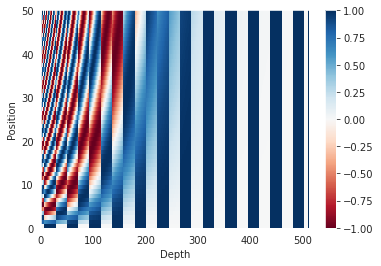

In [ ]:
pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

# **bold text**

In [ ]:
!pip install pyvi !pip install -U pip setuptools wheel
!pip install -U spacy
!python -m spacy download ja_core_news_sm

ERROR: Invalid requirement: '!pip'
     |████████████████████████████████| 6.0 MB 4.0 MB/s 
     |████████████████████████████████| 42 kB 1.3 MB/s 
     |████████████████████████████████| 653 kB 51.4 MB/s 
     |████████████████████████████████| 181 kB 40.1 MB/s 
     |████████████████████████████████| 451 kB 61.1 MB/s 
     |████████████████████████████████| 10.1 MB 31.2 MB/s 
  Attempting uninstall: catalogue
    Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Attempting uninstall: srsly
    Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srsly-1.0.5
  Attempting uninstall: thinc
    Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Attempting uninstall: spacy
    Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4
     |█████

In [ ]:
# read data
import string
ja_input = dataset_cn
vi_input = dataset_vn
# with open(f"/content/drive/MyDrive/Colab Notebooks/Project/dataMe/100chuong3xong/2999_Trung.xlsx") as f: for line in f: line = line.replace(' ', ' ').lower() vi_input.append(line.strip()) ja_input = []
# with open(f"/content/drive/MyDrive/Colab Notebooks/Project/dataMe/100chuong3xong/2999_Viet.xlsx") as f: for line in f: ja_input.append(line.strip()) for i in zip(ja_input[:5], vi_input[:5]): print(i)

In [ ]:
# Thêm token đánh dấu điểm bắt đầu và kết thúc của câu vào mỗi câu trong ngôn ngữ đích
eos = '<eos>'
bos = '<bos>' 
from pyvi import ViTokenizer
vi_input_tokenize = [ViTokenizer.tokenize(i).split() for i in vi_input]
for i in range(len(vi_input_tokenize)): vi_input_tokenize[i].insert(0, bos) vi_input_tokenize[i].insert(len(vi_input_tokenize[i]), eos) import spacy
nlp = spacy.load("ja_core_news_sm")
ja_input_tokenize = [[] for i in range(len(ja_input))]
for i in range(len(ja_input)): doc = nlp(ja_input[i]) for token in doc: ja_input_tokenize[i].append(str(token))

SyntaxError: ignored